In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. CSV laden
df = pd.read_csv('input/googleplaystore.csv')

# Erste Infos zum Datensatz
print(f"Anzahl Zeilen/Spalten: {df.shape}")
print(df.info())
print(df.head())

# 2. Fehlerhafte Zeilen entfernen (Beispiel: 'Installs' mit Text)
# Installs: Entfernen von '+' und ',' und Umwandeln in Integer
df = df[df['Installs'].str.contains(r'^\d[\d,]*\+$', na=False)]

# 3. 'Installs' bereinigen
df['Installs'] = df['Installs'].str.replace('+', '', regex=False)
df['Installs'] = df['Installs'].str.replace(',', '', regex=False).astype(int)

# 4. 'Price' bereinigen (Entfernen von '$', Umwandeln in float)
df['Price'] = df['Price'].str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 5. 'Reviews' in Integer umwandeln (ggf. ',' entfernen)
df['Reviews'] = df['Reviews'].astype(str).str.replace(',', '', regex=False)
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# 6. Fehlende Werte prüfen und ggf. entfernen
df.dropna(inplace=True)

# 7. Überblick nach Bereinigung
print(f"Nach Bereinigung: Anzahl Zeilen/Spalten: {df.shape}")
print(df.info())
print(df.head())

# 1. Size in MB umwandeln (wie vorher)
def convert_size_to_mb(size):
    if isinstance(size, str):
        size = size.strip()
        if size.endswith('M'):
            return float(size[:-1])
        elif size.endswith('k'):
            return float(size[:-1]) / 1000
        elif size == 'Varies with device':
            return np.nan
        else:
            try:
                return float(size)
            except:
                return np.nan
    else:
        return np.nan

df['Size_MB'] = df['Size'].apply(convert_size_to_mb)
df['Size_MB'] = df['Size_MB'].fillna(df['Size_MB'].median())

# 2. Last Updated in Tage seit heute
df['Last Updated'] = pd.to_datetime(df['Last Updated'])
today = pd.to_datetime('today')
df['Days_Since_Update'] = (today - df['Last Updated']).dt.days

# 3. Label Encoding der kategorialen Variablen
label_encoders = {}
for col in ['Category', 'Content Rating']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Zielvariable log-transformieren
y = np.log1p(df['Installs'])

# 5. Features (ohne Installs, Reviews, Type, Genres)
features = ['Category', 'Size_MB', 'Price', 'Content Rating', 'Days_Since_Update']
X = df[features]

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Anzahl Zeilen/Spalten: (10841, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & 

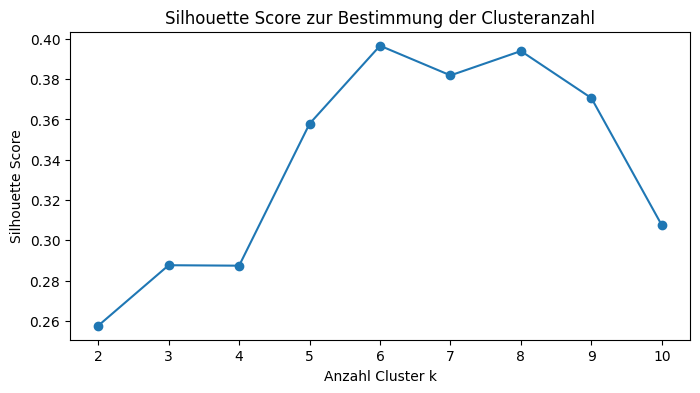

Optimal Anzahl Cluster: 6
Cluster-Zentren (ungefähr):
Cluster 0:
  Category: 25.23
  Size_MB: 13.54
  Price: 0.41
  Content Rating: 1.04
  Days_Since_Update: 2623.60

Cluster 1:
  Category: 14.12
  Size_MB: 68.60
  Price: 0.31
  Content Rating: 1.48
  Days_Since_Update: 2616.04

Cluster 2:
  Category: 17.88
  Size_MB: 9.53
  Price: 0.75
  Content Rating: 1.20
  Days_Since_Update: 3714.12

Cluster 3:
  Category: 13.73
  Size_MB: 8.90
  Price: 391.32
  Content Rating: 1.20
  Days_Since_Update: 2652.53

Cluster 4:
  Category: 9.78
  Size_MB: 15.33
  Price: 0.21
  Content Rating: 1.04
  Days_Since_Update: 2637.27

Cluster 5:
  Category: 14.73
  Size_MB: 22.03
  Price: 0.17
  Content Rating: 3.71
  Days_Since_Update: 2633.00

Cluster
0    3020
4    2951
5    1336
1    1104
2     934
3      15
Name: count, dtype: int64


In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Features aus deinem df auswählen
features = ['Category', 'Size_MB', 'Price', 'Content Rating', 'Days_Since_Update']
X = df[features]

# Features skalieren (K-Means ist empfindlich gegenüber unterschiedlicher Skalierung)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optimalen Wert für k (Anzahl Cluster) finden mit Silhouette Score
sil_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, cluster_labels)
    sil_scores.append(sil)

# Silhouette Score plotten
plt.figure(figsize=(8,4))
plt.plot(k_range, sil_scores, marker='o')
plt.title('Silhouette Score zur Bestimmung der Clusteranzahl')
plt.xlabel('Anzahl Cluster k')
plt.ylabel('Silhouette Score')
plt.show()

# K-Means mit optimalem k (z.B. k mit höchstem Silhouette Score) ausführen
optimal_k = k_range[np.argmax(sil_scores)]
print(f"Optimal Anzahl Cluster: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster-Zentren in Originalskala zurücktransformieren (optional)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print("Cluster-Zentren (ungefähr):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}:")
    for feat, val in zip(features, center):
        print(f"  {feat}: {val:.2f}")
    print()

# Beispiel-Auswertung: Anzahl Apps pro Cluster
print(df['Cluster'].value_counts())


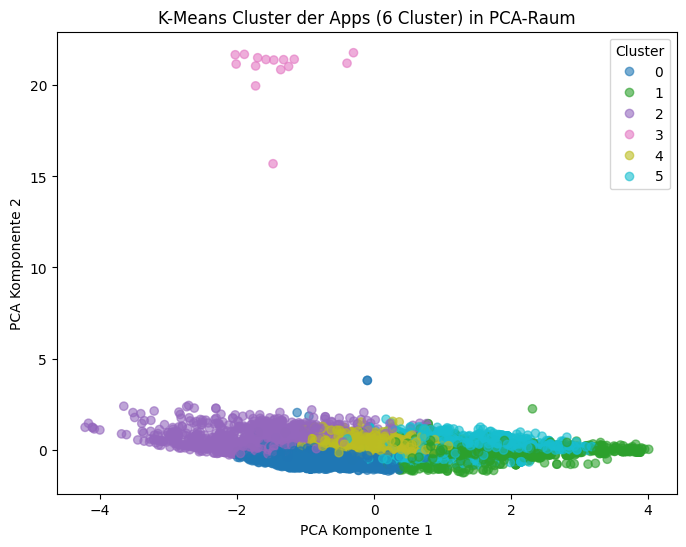

In [5]:
from sklearn.decomposition import PCA

# PCA auf die skalierten Features anwenden
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot der Cluster
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='tab10', alpha=0.6)
plt.xlabel('PCA Komponente 1')
plt.ylabel('PCA Komponente 2')
plt.title('K-Means Cluster der Apps (6 Cluster) in PCA-Raum')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()


In [7]:
for i, center in enumerate(cluster_centers):
    category_code = round(center[0])  # Kategorie ist Feature 0
    category_name = label_encoders['Category'].inverse_transform([category_code])[0]
    print(f"Cluster {i} Hauptkategorie: {category_name}")


Cluster 0 Hauptkategorie: PRODUCTIVITY
Cluster 1 Hauptkategorie: GAME
Cluster 2 Hauptkategorie: LIFESTYLE
Cluster 3 Hauptkategorie: GAME
Cluster 4 Hauptkategorie: EVENTS
Cluster 5 Hauptkategorie: HEALTH_AND_FITNESS




### Cluster 0: PRODUCTIVITY

* **Größe:** ca. 3000 Apps (eines der größten Cluster)
* **Merkmale:** Mittlere App-Größe (\~13.5 MB), eher niedriger Preis (\~0,41 \$), Content Rating niedrig (1,04) → vermutlich überwiegend für alle Altersgruppen freigegeben
* **Days Since Update:** ca. 7 Jahre (2623 Tage) – Apps werden eher selten aktualisiert
* **Beschreibung:** Dieses Cluster umfasst wahrscheinlich Produktivitäts-Apps wie Kalender, To-Do-Listen oder Office-Tools. Die Apps sind meist leichtgewichtig und preiswert oder kostenlos.

---

### Cluster 1: GAME

* **Größe:** ca. 1100 Apps
* **Merkmale:** Größere Apps (\~68.6 MB), niedriger Preis (\~0,31 \$), moderates Content Rating (1,48) → evtl. etwas ältere Zielgruppe oder etwas eingeschränkter
* **Days Since Update:** ähnlich alt wie Cluster 0 (2616 Tage)
* **Beschreibung:** Spiele mit mittlerer bis großer Dateigröße, preislich meist günstig oder kostenlos, die etwas ältere Aktualisierungsintervalle haben.

---

### Cluster 2: LIFESTYLE

* **Größe:** ca. 900 Apps
* **Merkmale:** Kleinere Apps (\~9.5 MB), etwas höherer Preis (\~0,75 \$), Content Rating 1,20
* **Days Since Update:** deutlich älter (3714 Tage ≈ 10 Jahre)
* **Beschreibung:** Lifestyle-Apps wie Fitness, Mode, Essen & Trinken oder Dating, meist kompakt und eher selten aktualisiert, etwas teurer als die vorherigen Cluster.

---

### Cluster 3: GAME (teuer)

* **Größe:** sehr klein, nur 15 Apps
* **Merkmale:** Kleine Größe (\~8.9 MB), extrem hoher Preis (\~391 \$), Content Rating 1,20
* **Days Since Update:** ähnlich wie andere (2652 Tage)
* **Beschreibung:** Wahrscheinlich spezielle oder Premium-Spiele mit sehr hohem Preis, vielleicht Nischen- oder professionelle Spiele oder Entwickler-Apps.

---

### Cluster 4: EVENTS

* **Größe:** ca. 2950 Apps (ebenfalls sehr groß)
* **Merkmale:** Mittlere Größe (\~15.3 MB), sehr niedriger Preis (\~0,21 \$), Content Rating 1,04
* **Days Since Update:** ca. 7 Jahre
* **Beschreibung:** Apps rund um Veranstaltungen, Ticketing, Kalender oder Community-Events, meist günstig und nicht sehr groß.

---

### Cluster 5: HEALTH\_AND\_FITNESS

* **Größe:** ca. 1300 Apps
* **Merkmale:** Mittlere Größe (\~22 MB), sehr niedriger Preis (\~0,17 \$), hoher Content Rating (3,71) → evtl. mehr Altersbeschränkungen oder spezielle Inhalte
* **Days Since Update:** ca. 7 Jahre
* **Beschreibung:** Fitness- und Gesundheits-Apps mit etwas höherem Schutz (z.B. 12+, 16+), preislich sehr günstig, mittelgroß in der Dateigröße.

---


